In [81]:
import numpy as np
import scipy.linalg
import scipy.io
from scipy.interpolate import griddata
%matplotlib inline

def trans_cov(dat, cov, mean=np.array([[0],[0]])):
    evals, evecs = scipy.linalg.eigh(cov)
    c = np.dot(evecs, np.diag(np.sqrt(evals)))
    res = np.dot(c,dat)
    if not np.allclose(np.round(np.cov(res)), cov):
        print(np.cov(res))
    res = res + mean
    assert np.allclose(np.round(np.mean(res, axis=1)), mean.T[0])
    
    return res

In [64]:
dats = [
            [trans_cov(np.random.randn(2, 200), np.eye(2)),
             trans_cov(np.random.randn(2, 200), np.eye(2), np.array([[3],[0]]))],
    
            [trans_cov(np.random.randn(2, 200), np.array([[4,3],[3,4]]), np.array([[-1],[0]])),
             trans_cov(np.random.randn(2, 200), np.array([[4,3],[3,4]]), np.array([[1],[0]]))],
    
            [trans_cov(np.random.randn(2, 200), np.array([[3,1],[1,2]])),
             trans_cov(np.random.randn(2, 200), np.array([[7,-3],[-3,4]]), np.array([[3],[0]]))]
        ]

[[ 4.9688767   4.01228431]
 [ 4.01228431  4.98736423]]
[[ 7.26463787 -2.73404723]
 [-2.73404723  3.45253762]]


In [65]:
dats.append([scipy.io.loadmat("case4.mat")["a"].T, scipy.io.loadmat("case4.mat")["b"].T])

In [66]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

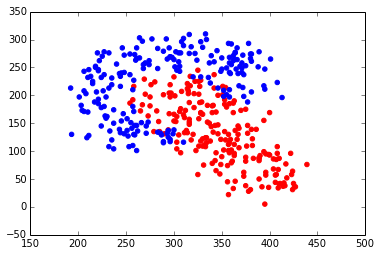

In [67]:
dat = dats[3]
fig = plt.figure()
plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.show()

In [68]:
def med(c1, c2):
    """Create an med function"""
    z1 = np.mean(c1, axis=1)
    z2 = np.mean(c2, axis=1)
    def f(x):
        return -np.dot(z1,x) + 0.5*np.dot(z1.T,z1) < -np.dot(z2,x) + 0.5*np.dot(z2.T,z2)
    return f

In [69]:
from numpy.linalg import norm, inv

def map_class(c1, c2):
    e1 = np.cov(c1)
    e2 = np.cov(c2)
    u1 = np.mean(c1, axis=1)
    u2 = np.mean(c2, axis=1)
    
    def f(x):
        # how do I vectorize this?
        return np.log(np.sqrt(norm(e2))/np.sqrt(norm(e1))) \
               -0.5*np.dot(np.dot((x - u1),inv(e1)),(x - u1).T) \
               +0.5*np.dot(np.dot((x - u2),inv(e2)),(x - u2).T) \
                < 0
    return f

In [72]:
def ged(c1, c2):
    s1 = inv(np.cov(c1))
    s2 = inv(np.cov(c2))
    u1 = np.mean(c1, axis=1)
    u2 = np.mean(c2, axis=1)
    
    def f(x):
        return np.sqrt(np.dot(np.dot((x - u1),s1),(x - u1).T)) > \
               np.sqrt(np.dot(np.dot((x - u2),s2),(x - u2).T)) 
        
    return f

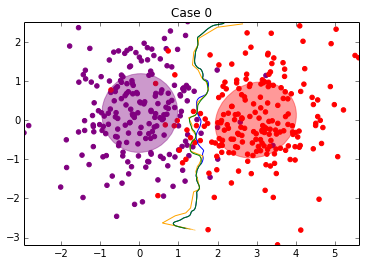

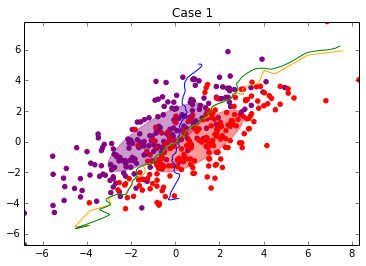

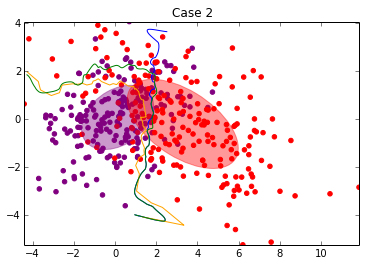

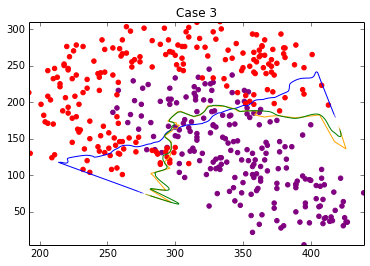

In [82]:
for i_d, dat in enumerate(dats):
    # basic plotting
    fig = plt.figure()
    plt.scatter(dat[0][0], dat[0][1], color="purple")
    plt.scatter(dat[1][0], dat[1][1], color="red")
    if i_d != 3:
        plot_cov_ellipse(cov=np.cov(dat[0].T, rowvar=False), pos=np.mean(dat[0].T, axis=0), nstd=1, alpha=0.4, color='purple')
        plot_cov_ellipse(cov=np.cov(dat[1].T, rowvar=False), pos=np.mean(dat[1].T, axis=0), nstd=1, alpha=0.4, color='red')
    plt.title("Case %s" %i_d)
    
    # set the grid up
    all_dat = np.concatenate((dat[0], dat[1]), axis=1).T
    min_x = np.min(all_dat[:, 0])
    max_x = np.max(all_dat[:, 0])
    min_y = np.min(all_dat[:, 1])
    max_y = np.max(all_dat[:, 1])
    sample_points = 1000
    x = np.linspace(min_x, max_x, sample_points)
    y = np.linspace(min_y, max_y, sample_points)
    grid_x, grid_y = np.meshgrid(x, y)
    
    # MED classifier and plot
    med_func = med(dat[0], dat[1])
    res = med_func(all_dat.T)
    a_res = np.array(res, dtype=np.int)
    a_res[a_res == 0] = -1

    grid_res = griddata(all_dat, a_res, (grid_x, grid_y), method='cubic')
    plt.contour(grid_x.T, grid_y.T, grid_res.T, levels=[0], colors='blue')
    
    # GED classifier and plot
    ged_func = ged(dat[0], dat[1])
    dat_list = list(np.concatenate((dat[0], dat[1]), axis=1).T)

    res = []
    for d_l in dat_list:
        res.append(ged_func(d_l))

    a_res = np.array(res, dtype=np.int)
    a_res[a_res == 0] = -1

    grid_res = griddata(all_dat, a_res, (grid_x, grid_y), method='linear')
    plt.contour(grid_x.T, grid_y.T, grid_res.T, levels=[0], colors='orange')

    # MAP classifier and seperation line
    map_func = map_class(dat[0], dat[1])
    dat_list = list(np.concatenate((dat[0], dat[1]), axis=1).T)

    res = []
    for d_l in dat_list:
        res.append(map_func(d_l))

    a_res = np.array(res, dtype=np.int)
    a_res[a_res == 0] = -1

    grid_res = griddata(all_dat, a_res, (grid_x, grid_y), method='cubic')
    plt.contour(grid_x.T, grid_y.T, grid_res.T, levels=[0], colors='green')
    
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    fig.savefig("case%s" %i_d)

In [45]:
def knn(c1, c2, k):
    # initiaslise with K points from each class
    zero_shape = (c1.shape[0], c1.shape[1]*2)
    c1_res = np.zeros(zero_shape)
    c1_count = 0
    c2_res = np.zeros(zero_shape)
    c2_count = 0
    c_all = np.concatenate((c1, c2), axis=1)

    # because numpy nditer is psychotic
    for c_ind in xrange(c_all.shape[1]):
        val = c_all[:, c_ind]
        #find the nearest K neighbours
        if np.allclose(val, np.array([-2, 0])):
            ipdb.set_trace()
        ind = np.argpartition(norm(c_all.T - val, axis=1), k+1)[:k+1][1:k+1]
        
        # class the point where the majority of the neighbours are
        sort_res = 0
        for ix in ind:
            if ix < c1.shape[1]:
                sort_res += 1
            else:
                sort_res -= 1

        if sort_res > 0:
            c1_res[:, c1_count] = val
            c1_count += 1
        else:
            c2_res[:, c2_count] = val
            c2_count += 1

    assert c1_count + c2_count == c1.shape[1] + c1.shape[1]
    return (c1_res[:, :c1_count], c2_res[:, :c2_count])

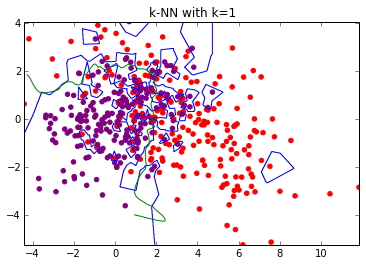

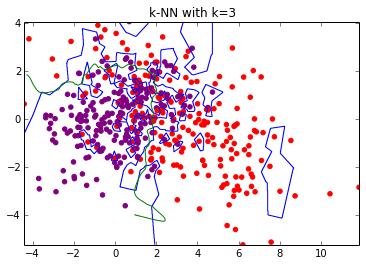

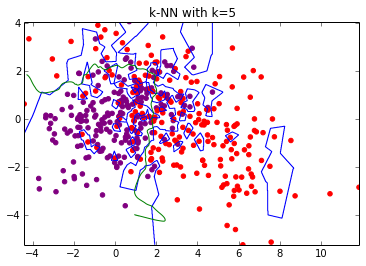

In [83]:
dat = dats[2]

# set the grid up
all_dat = np.concatenate((dat[0], dat[1]), axis=1).T
min_x = np.min(all_dat[:, 0])
max_x = np.max(all_dat[:, 0])
min_y = np.min(all_dat[:, 1])
max_y = np.max(all_dat[:, 1])
sample_points = 1000
x = np.linspace(min_x, max_x, sample_points)
y = np.linspace(min_y, max_y, sample_points)
grid_x, grid_y = np.meshgrid(x, y)

# MAP classifier and seperation line
map_func = map_class(dat[0], dat[1])
dat_list = list(np.concatenate((dat[0], dat[1]), axis=1).T)

res = []
for d_l in dat_list:
    res.append(map_func(d_l))

a_res = np.array(res, dtype=np.int)
a_res[a_res == 0] = -1

map_grid_res = griddata(all_dat, a_res, (grid_x, grid_y), method='cubic')

for k in [1, 3, 5]:
    
    # basic plotting
    fig = plt.figure()
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.scatter(dat[0][0], dat[0][1], color="purple")
    plt.scatter(dat[1][0], dat[1][1], color="red")
    plt.title("k-NN with k=%s" %k)
    
    # KNN classifier and plot
    res1, res2 = knn(dat[0], dat[1], k)
    a_res = np.concatenate((np.ones(res1.shape[1]), np.ones(res2.shape[1])*-1))
    grid_res = griddata(all_dat, a_res, (grid_x, grid_y), method='nearest')

    plt.contour(grid_x.T, grid_y.T, grid_res.T, levels=[0], colors='blue')
    plt.contour(grid_x.T, grid_y.T, map_grid_res.T, levels=[0], colors='green') 
    fig.savefig("knn%s" %k)